# IMPORTING REQUIRED LIBRARIES

In [250]:
import pandas as pd
import pylab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_finance import candlestick2_ochl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# LOADING THE DATASET 

The Frankfurt Stock Exchange (FSE) data feed contains daily stock prices from the exchange.

In [251]:
data = pd.read_csv('FSE-PUM_X.csv') # Reading the data from the FSE-PUM_X.csv

# EXPLORATORY DATA ANALYSIS

In [252]:
data.head() 

,Date,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
0,2019-03-01,NaN,506.0,497.5,501.0,NaN,48253.0,24163738.0,NaN,NaN,NaN
1,2019-02-28,NaN,496.0,480.5,495.5,NaN,60038.0,29546756.0,NaN,NaN,NaN
2,2019-02-27,NaN,482.5,475.5,482.0,NaN,29863.0,14336548.0,NaN,NaN,NaN
3,2019-02-26,NaN,484.5,475.5,482.5,NaN,37216.0,17941044.0,NaN,NaN,NaN
4,2019-02-25,NaN,487.5,466.0,480.5,NaN,70333.0,33755323.0,NaN,NaN,NaN


In [253]:
print("The given dataset contains ",data.shape[1],"columns")
print("The given dataset contains ",data.shape[0],"entries")

The given dataset contains  11 columns
The given dataset contains  4927 entries


In [254]:
print("The Date column of the dataset is: ",type(data['Date'][0])) # The Date column is of the string type

#Converting the string type Date column to a datetime stamp.

data['Date'] = pd.to_datetime(data['Date'],format = '%Y-%m-%d')
print("Now the type of the Date column is: ",type(data['Date'][0]))


The Date column of the dataset is:  <class 'str'>
Now the type of the Date column is:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [255]:
# Sorting the Date column in ascending order.
data = data.set_index('Date')
data = data.sort_index(axis=0 ,ascending=True)

In [256]:
data.head()


,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2000-01-19,NaN,NaN,NaN,15.40,NaN,0.0,NaN,NaN,NaN,0.0
2000-01-20,NaN,NaN,NaN,15.50,NaN,0.0,NaN,NaN,NaN,0.0
2000-01-21,NaN,NaN,NaN,15.50,NaN,0.0,NaN,NaN,NaN,0.0
2000-01-24,NaN,NaN,NaN,16.22,NaN,0.0,NaN,NaN,NaN,0.0
2000-01-25,NaN,NaN,NaN,16.22,NaN,0.0,NaN,NaN,NaN,0.0


In [257]:
print("The number of Nan values in each column: ")
print(data.isna().sum())

The number of Nan values in each column: 
Open                      793
High                      497
Low                       497
Close                       0
Change                   4916
Traded Volume              47
Turnover                 1456
Last Price of the Day    4927
Daily Traded Units       4927
Daily Turnover           3518
dtype: int64


In [258]:
arr = data.columns
print("Percentage of Nan values in each column:")
for i in arr:
    val = (data[i].isna().sum()/data.shape[0])*100
    print(str(i)+" "+": "+str(round(val,2))+"%")

Percentage of Nan values in each column:
Open : 16.09%
High : 10.09%
Low : 10.09%
Close : 0.0%
Change : 99.78%
Traded Volume : 0.95%
Turnover : 29.55%
Last Price of the Day : 100.0%
Daily Traded Units : 100.0%
Daily Turnover : 71.4%


# IMPLEMENTING MOVING AVERAGE CONVERGENCE AND DIVERGENCE (MACD)

- MACD is calculated by subtracting the long-term EMA (26 periods) from the short-term EMA (12 periods).
- An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. 
- The exponential moving average is also referred to as the exponentially weighted moving average. 
- Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two  moving averages of a security’s price.
- The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The result of  that calculation is the MACD line.
- A nine-day EMA of the MACD, called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. 

In [260]:
#Function for calculating moving averages
def moving_average(x, n, type='simple'):
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))
    weights /= weights.sum()
    #print(x)
    print()
    a = np.convolve(x, weights, mode='full')[:len(x)]
    #print(a)
    a[:n] = a[n]
    return a

# SOME IMPORTANT POINTS ABOUT CONVERGENCE AND DIVERGENCE OF MOVING AVERAGES
- **Convergence** occurs when the moving averages move towards each other.
- **Divergence** occurs when the moving averages move away from each other.
- **Signal Line** is a 9 day EMA of a MACD line.
- The shorter moving average(12 days) is faster and is responsible for most of the MACD movements.
- The longer moving average(26 days) is slower and less reactive to price changes in the underlying security. 

In [261]:
# Function for moving average convergence.
def moving_average_convergence(x, nslow=26, nfast=12):
    
    emaslow = moving_average(x, nslow, type='exponential') #long moving average
    
    emafast = moving_average(x, nfast, type='exponential') #short moving average
    
    return emaslow, emafast, emafast - emaslow


In [262]:
# Function for Relative strength indicator.
def relative_strength(prices, n=14):

    deltas = np.diff(prices)
    
    seed = deltas[:n+1]
    
    up = seed[seed >= 0].sum()/n
    
    down = -seed[seed < 0].sum()/n
    
    rs = up/down
    
    rsi = np.zeros_like(prices)
    
    rsi[:n] = 100. - 100./(1. + rs)
    
    for i in range(n, len(prices)):
        
        delta = deltas[i - 1] 

        if delta > 0:
            upval = delta
            downval = 0.
        
        else:
            upval = 0.
            
            downval = -delta
        
        up = (up*(n - 1) + upval)/n
        
        down = (down*(n - 1) + downval)/n

        rs = up/down
        
        rsi[i] = 100. - 100./(1. + rs)
    
    return rsi

In [266]:
# Parameters for calculating MACD and Signal Lines

nslow = 26    #slow window  

nfast = 12    #fast window

nema = 9

prices = data['Close']

emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)

ema9 = moving_average(macd, nema, type='exponential')

rsi = relative_strength(prices)

wins = 100

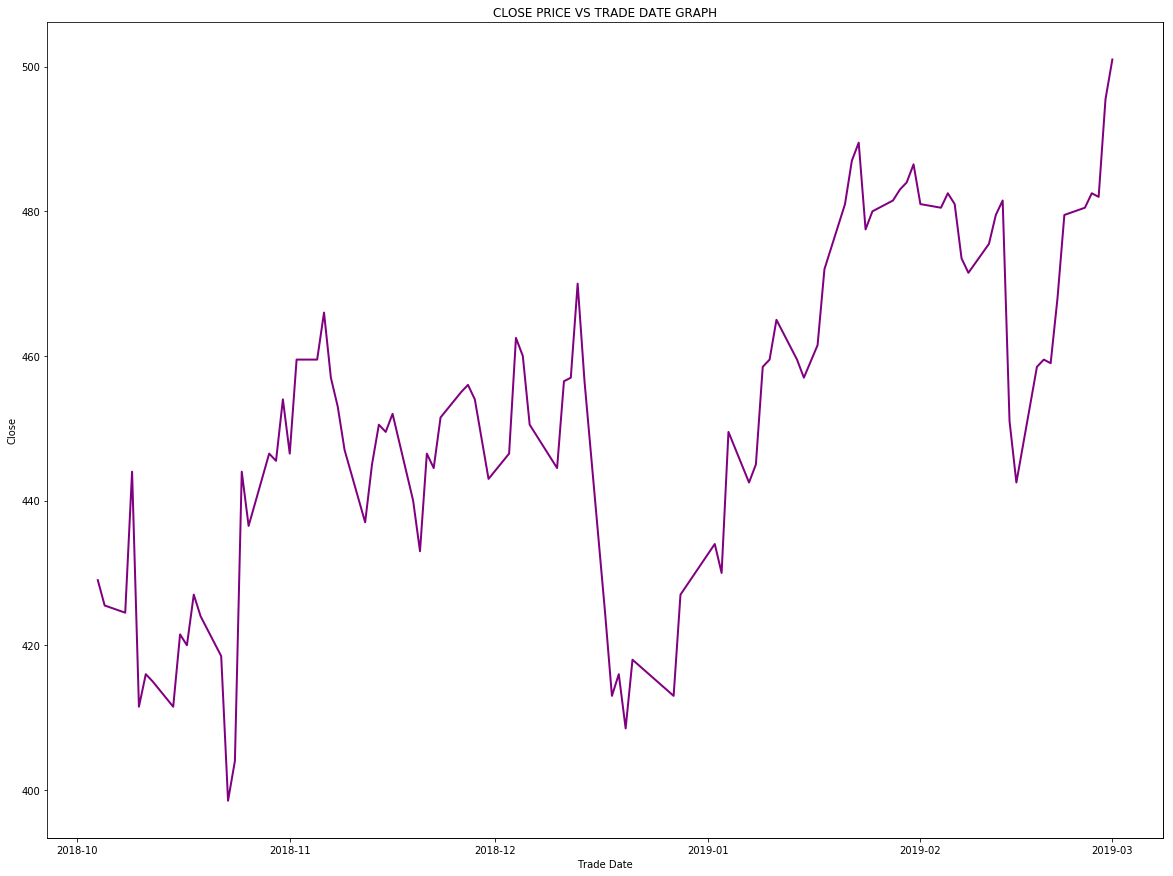

In [267]:
fig = plt.figure(figsize=(20,15))

plt.xticks([])
plt.yticks([])

plt.title("CLOSE PRICE VS TRADE DATE GRAPH")

plt.xticks(rotation=90)

ax1 = fig.add_subplot(111, ylabel = 'Close',xlabel='Trade Date')

plt.plot(prices[-wins:], 'k', lw = 2,color='purple')

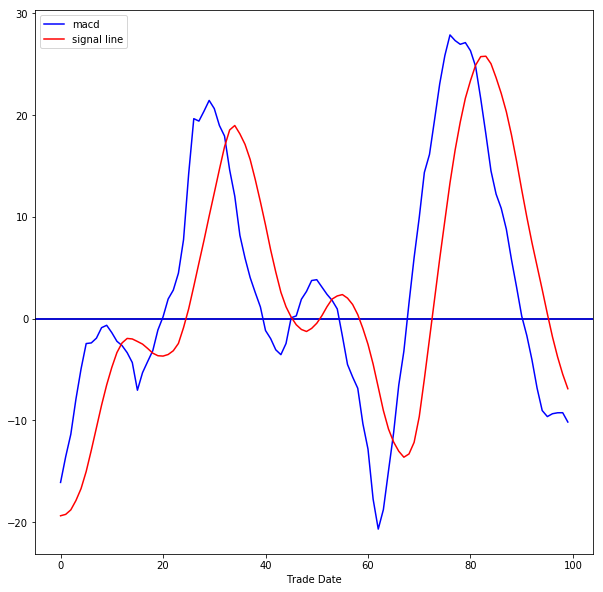

In [268]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111,xlabel='Trade Date')

plt.axhline(y=0, color='black', linestyle='-')

plt.axhline(y=0, color='b', linestyle='-')

pylab.plot(macd[-wins:], '-b', label='macd')
pylab.plot(ema9[-wins:], '-r', label='signal line')
pylab.legend(loc='upper left')

# OUTCOMES 

- A **bullish crossover** occurs when the MACD turns up and crosses above the signal line.
- A **bearish crossover** occurs when the MACD turns down and crosses below the signal line.
- For positive MACD 12 day EMA is above 26 day EMA.
  The positive value increases as the shorter EMA diverges further from the longer EMA. This means **upside momentum is increasing**.
- For negaive MACD 12 day EMA is below 26 day EMA.
  The negative value increases as the shorter EMA diverges further below the longer EMA. This means **downside momentum is       increasing.**
- MACD triggers technical signals when it crosses above (to buy) or below (to sell) its signal line.
- MACD helps investors understand whether bullish or bearish movement in the price is strengthening or weakening.